# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [5]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score
!pip install -U -q chardet

In [6]:
# Import essential libraries

import os
import pandas as pd
from tqdm import tqdm
import zipfile
import os
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import chardet
import os
import numpy as np

In [7]:
## Load Environment Variables

from dotenv import load_dotenv

# Load environment variables from a .env file if present
load_dotenv()

# to set env var create a .env file in the root directory and add the key value pair
# Example: Access an environment variable (e.g., OPENAI_API_KEY)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

#### Uploading the dataset: The dataset is being uploaded manually for more control and transparency at this stage.

#### Optional - Only for Google Colab

In [ ]:
# Load the files as documents

# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Uploading the zip file
zip_path = '/content/drive/MyDrive/Colab Notebooks/rag_legal.zip'


In [ ]:
# Destination folder after extraction
extract_path = '/content/legal_docs_dataset'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed")

Extraction completed


In [ ]:
# List the contents of the extracted directory
for root, dirs, files in os.walk(extract_path):
    print(f"\n📁 Directory: {root}")
    for file in files:
        print(f"  └── 📄 {file}")



📁 Directory: /content/legal_docs_dataset

📁 Directory: /content/legal_docs_dataset/rag_legal

📁 Directory: /content/legal_docs_dataset/rag_legal/benchmarks
  └── 📄 contractnli.json
  └── 📄 privacy_qa.json
  └── 📄 maud.json
  └── 📄 cuad.json

📁 Directory: /content/legal_docs_dataset/rag_legal/corpus

📁 Directory: /content/legal_docs_dataset/rag_legal/corpus/contractnli
  └── 📄 5-NSK-Confidentiality-Agreement-for-Suppliers.txt
  └── 📄 NDA-Dollar-General-Portfolio.txt
  └── 📄 CBP_20Non-Disclosure_20Form_October2018.txt
  └── 📄 BT_NDA.txt
  └── 📄 12032018_NDA_The_20Munt_EN.txt
  └── 📄 Kenway-NDA-Form-Blank.txt
  └── 📄 Grindrod_20SA_20Confidentiality_20and_20Non-Disclosure_20Undertaking.txt
  └── 📄 NDA-Artop-Inno-2017.txt
  └── 📄 NCDG_Non-disclosure-agreement.txt
  └── 📄 JBF_NDA_rev-2017033-1.txt
  └── 📄 SINTEC-UK-LTD-Non-disclosure-agreement-2017.txt
  └── 📄 NDA-ONSemi_IndustryAnalystConf-2011.txt
  └── 📄 Data Use Agreement New York City.txt
  └── 📄 eHandshake_Non_Disclosure_Agreement.txt

In [ ]:
# Set the path

corpus_path = '/content/legal_docs_dataset/rag_legal/corpus'

##### For Local Development

In [8]:
### Step 1: Extract the files from ./rag_legal.zip

# Define paths
zip_path = './rag_legal.zip'
extract_path = './legal_docs_dataset'

# Create extraction directory if it doesn't exist
import os
os.makedirs(extract_path, exist_ok=True)

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed")

### Step 2: Read the files and directory from the extracted folder

# List all files and directories
print(f"Files extracted to: {extract_path}")
print("\nDirectory structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")

# Count total files
total_files = sum([len(files) for root, dirs, files in os.walk(extract_path)])
print(f"\nTotal files extracted: {total_files}")

Extraction completed
Files extracted to: ./legal_docs_dataset

Directory structure:
legal_docs_dataset/
  rag_legal/
    corpus/
      maud/
        The Michaels Companies, Inc._Apollo Global Management, LLC.txt
        WPX Energy, Inc._Devon Energy Corporation.txt
        DSP_Group_Synaptics_Incorporated.txt
        Foundation Building Materials, Inc._American Securities LLC.txt
        Century Bancorp, Inc._Eastern Bankshares, Inc..txt
        Covanta_Holding_Corporation_EQT_Holdings_AB.txt
        Five Prime Therapeutics, Inc._Amgen Inc..txt
        Inphi Corporation_Marvell Technology Group Ltd..txt
        Boingo Wireless, Inc._Digital Colony Partners, LP.txt
        W_R_Grace_Co_40_North_Management_LLC.txt
        Viela Bio, Inc._Horizon Therapeutics Public Limited Company.txt
        Alaska Communications Systems Group, Inc._Investment Group.txt
        Cloudera, Inc._Investment Group.txt
        Pluralsight, Inc._Vista Equity Partners.txt
        PRA Health Sciences, Inc._ICON 

In [ ]:
# Load the Text files

# Storage for all documents
documents = []

# Loop through each subfolder in the corpus
for folder_name in os.listdir(corpus_path):
    folder_path = os.path.join(corpus_path, folder_name)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            if file_name.endswith('.txt'):
                try:
                    # Detect encoding
                    with open(file_path, 'rb') as raw_file:
                        encoding = chardet.detect(raw_file.read())['encoding'] or 'utf-8'

                    # Read file content
                    with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
                        content = f.read()

                    # Store with metadata
                    documents.append({
                        'file_name': file_name,
                        'folder': folder_name,
                        'file_path': file_path,
                        'content': content
                    })

                except Exception as e:
                    print(f"❌ Error reading file: {file_path}\n{e}")

# Convert to DataFrame for further processing
df_docs = pd.DataFrame(documents)

# Show summary
print(f"Loaded {len(df_docs)} text files from corpus.")
df_docs.head()

Loaded 698 text files from corpus.


,file_name,folder,file_path,content
0,5-NSK-Confidentiality-Agreement-for-Suppliers.txt,contractnli,/content/legal_docs_dataset/rag_legal/corpus/c...,NON-DISCLOSURE AGREEMENT\nThis Agreement is ef...
1,NDA-Dollar-General-Portfolio.txt,contractnli,/content/legal_docs_dataset/rag_legal/corpus/c...,Confidentiality Agreement – Non-Disclosure Agr...
2,CBP_20Non-Disclosure_20Form_October2018.txt,contractnli,/content/legal_docs_dataset/rag_legal/corpus/c...,DEPARTMENT OF HOMELAND SECURITY\nNON-DISCLOSUR...
3,BT_NDA.txt,contractnli,/content/legal_docs_dataset/rag_legal/corpus/c...,CONFIDENTIALITY AND NON-DISCLOSURE AGREEEMENT\...
4,12032018_NDA_The_20Munt_EN.txt,contractnli,/content/legal_docs_dataset/rag_legal/corpus/c...,Confidentiality Agreement\nThis Confidentialit...


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

### Preprocessing Steps:

 - Lowercasing: Convert all text to lowercase to ensure uniformity.

 - Remove Special Characters & Extra Whitespace: Eliminate non-alphanumeric characters (except periods, commas, etc.) and multiple spaces.

 - Remove Email, Phone Numbers, and URLs: Use regular expressions (regex) to filter out any email addresses, phone numbers, or URLs that may appear in the text.

 - Tokenization & Stopword Removal: Split the text into tokens (words) and remove common stopwords (e.g., "the", "is", "and").

 - Handle Missing or Corrupted Data: Skip files that are corrupted or have missing content, and log the errors.

In [ ]:
# Clean and preprocess the data

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove phone numbers (pattern assumes standard format like (xxx) xxx-xxxx or xxx-xxx-xxxx)
    text = re.sub(r'\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}', '', text)

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove multiple spaces
    text = re.sub(r'\n{2,}', '\n', text)

    # Remove Page Numbers
    text = re.sub(r'Page\s+\d+', '', text)

    # Remove Headers/Footers
    text = re.sub(r'\s{2,}', ' ', text)

    return text

# Function to process and clean documents
def clean_documents(doc_df):
    # Remove rows with missing content
    doc_df = doc_df.dropna(subset=['content'])

    # Clean each document
    doc_df['cleaned_content'] = doc_df['content'].apply(preprocess_text)

    return doc_df

# Load dataset
corpus_path = '/content/legal_docs_dataset/rag_legal/corpus'

df_docs = clean_documents(df_docs)

# Example check
print(f"Cleaned {len(df_docs)} documents.")
print(df_docs[['file_name', 'cleaned_content']].head())

Cleaned 698 documents.
                                           file_name  \
0  5-NSK-Confidentiality-Agreement-for-Suppliers.txt   
1                   NDA-Dollar-General-Portfolio.txt   
2        CBP_20Non-Disclosure_20Form_October2018.txt   
3                                         BT_NDA.txt   
4                     12032018_NDA_The_20Munt_EN.txt   

                                     cleaned_content  
0  nondisclosure agreement this agreement is effe...  
1  confidentiality agreement nondisclosure agreem...  
2  department of homeland security nondisclosure ...  
3  confidentiality and nondisclosure agreeement b...  
4  confidentiality agreement this confidentiality...  


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

### Exploring the data to understand the legal document dataset, its structure, content and pattenrs

In [ ]:
# Dataset Overview

df_docs.head()
df_docs.info()
df_docs.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_name        698 non-null    object
 1   folder           698 non-null    object
 2   file_path        698 non-null    object
 3   content          698 non-null    object
 4   cleaned_content  698 non-null    object
dtypes: object(5)
memory usage: 27.4+ KB


,file_name,folder,file_path,content,cleaned_content
count,698,698,698,698,698
unique,698,4,698,696,696
top,PHLVARIABLEINSURANCECOCT_08_17_2009-EX-10.1-ST...,cuad,/content/legal_docs_dataset/rag_legal/corpus/c...,Exhibit 10.7\n\nCONSULTING AGREEMENT\n\nAduro ...,exhibit consulting agreement aduro biotech inc...
freq,1,462,1,2,2


In [ ]:
# Document counts per folder

df_docs['folder'].value_counts()

,count
folder,
cuad,462
maud,134
contractnli,95
privacy_qa,7


In [ ]:
# Number of Words per document

df_docs['num_words'] = df_docs['cleaned_content'].apply(lambda x: len(x.split()))
df_docs[['folder','num_words']].describe()


,num_words
count,698.000000
mean,15683.120344
std,20406.696481
min,207.000000
25%,2356.250000
50%,5698.000000
75%,19310.750000
max,153799.000000


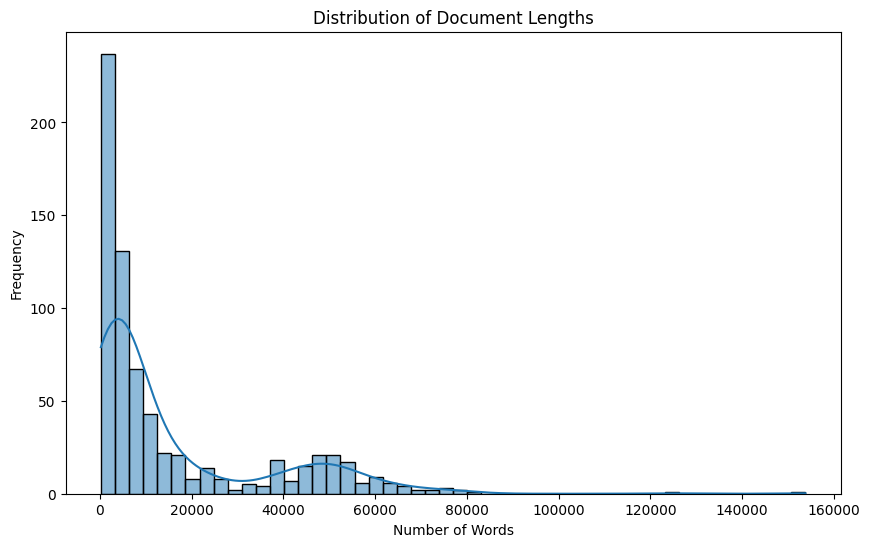

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_docs['num_words'], bins=50, kde=True)
plt.title('Distribution of Document Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [ ]:
# Calculate the average, maximum and minimum document length.

# Calculate document length (in terms of word count)
df_docs['doc_length'] = df_docs['cleaned_content'].apply(lambda x: len(x.split()))

# Calculate average, max, and min document length
avg_length_bef = df_docs['doc_length'].mean()
max_length_bef = df_docs['doc_length'].max()
min_length_bef = df_docs['doc_length'].min()

print(f"Average Document Length: {avg_length_bef:.2f} words")
print(f"Maximum Document Length: {max_length_bef} words")
print(f"Minimum Document Length: {min_length_bef} words")



Average Document Length: 15683.12 words
Maximum Document Length: 153799 words
Minimum Document Length: 207 words


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [ ]:
import nltk
from nltk.data import find

# Clear NLTK cache
nltk.data.path = ['/root/nltk_data']  # Reset path if needed
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Find frequency of occurence of words

import re
from nltk.corpus import stopwords

# Loading stopwords
stop_words = set(stopwords.words('english'))

# Custom Tokenization function using regex
def clean_and_tokenize(text):
    try:
        # Tokenize using regex- split on non-alphabetic characters and lower case
        words = re.findall(r'\b\w+\b', text.lower())
        # Removed stopwords and non-alphabetic tokens
        return [word for word in words if word not in stop_words]
    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

# Apply the custom tokenizer to the cleaned content
df_docs['tokens'] = df_docs['cleaned_content'].apply(clean_and_tokenize)

# Check the first few tokenized documents
print(df_docs[['file_name', 'tokens']].head())


                                           file_name  \
0  5-NSK-Confidentiality-Agreement-for-Suppliers.txt   
1                   NDA-Dollar-General-Portfolio.txt   
2        CBP_20Non-Disclosure_20Form_October2018.txt   
3                                         BT_NDA.txt   
4                     12032018_NDA_The_20Munt_EN.txt   

                                              tokens  
0  [nondisclosure, agreement, agreement, effectiv...  
1  [confidentiality, agreement, nondisclosure, ag...  
2  [department, homeland, security, nondisclosure...  
3  [confidentiality, nondisclosure, agreeement, t...  
4  [confidentiality, agreement, confidentiality, ...  


In [ ]:
# After tokenization

# Calculate the length of each document (number of tokens)
df_docs['doc_length'] = df_docs['tokens'].apply(len)

# Calculate average, maximum, and minimum document length
avg_length_after = df_docs['doc_length'].mean()
max_length_after = df_docs['doc_length'].max()
min_length_after = df_docs['doc_length'].min()

print(f"Average Document Length: {avg_length_after}")
print(f"Maximum Document Length: {max_length_after}")
print(f"Minimum Document Length: {min_length_after}")


Average Document Length: 8620.320916905444
Maximum Document Length: 82546
Minimum Document Length: 132


In [ ]:
# Get the most common and least common words

from collections import Counter

# Flatten the list of tokens
all_tokens = [token for tokens in df_docs['tokens'] for token in tokens]

# Get the frequency of each word
word_freq = Counter(all_tokens)

In [ ]:
# Get the 20 most common words
most_common_words = word_freq.most_common(20)

print("20 Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

20 Most Common Words:
company: 148175
shall: 107998
agreement: 104577
section: 75368
parent: 58010
party: 49664
date: 39300
time: 35256
material: 34211
merger: 33848
subsidiaries: 33318
b: 31719
applicable: 31370
including: 29399
respect: 28848
may: 28114
stock: 26654
information: 25687
parties: 24614
business: 23531


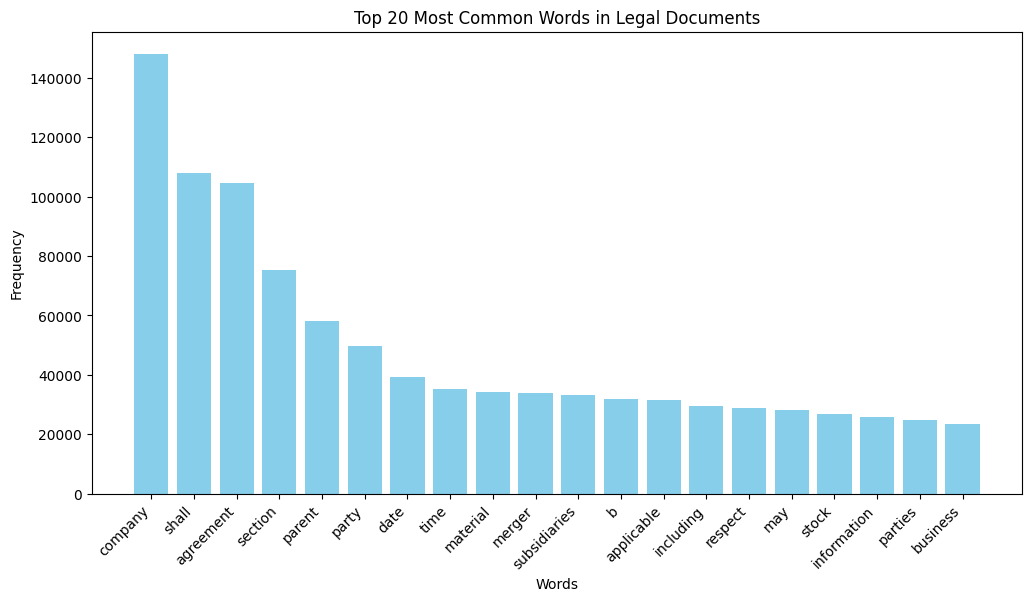

In [ ]:
# Bar plotof Most Common words

import matplotlib.pyplot as plt

# Separate words and counts
words, counts = zip(*most_common_words)

plt.figure(figsize=(12,6))
plt.bar(words, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Common Words in Legal Documents")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Get the 20 least common words
least_common_words = word_freq.most_common()[-20:]

print("20 Least Common Words:")
for word, freq in least_common_words:
    print(f"{word}: {freq}")

20 Least Common Words:
wwwcontinentalcom: 1
canons: 1
rickmansworth: 1
herts: 1
serono: 1
anvisa: 1
corroded: 1
notw: 1
tand: 1
ob: 1
iga: 1
mhra: 1
orchard: 1
px: 1
lunchtime: 1
betasp: 1
viewership: 1
distasteful: 1
cabledate: 1
mediadate: 1


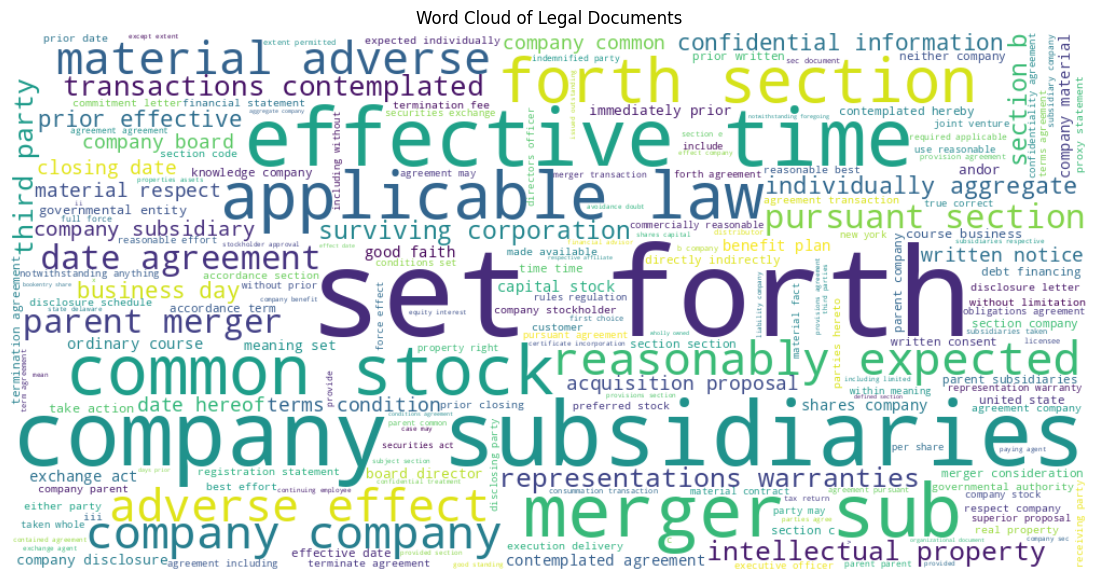

In [ ]:
# Word Cloud of Most Frequent words

from wordcloud import WordCloud

# Combine all words into a single string for the wordcloud
all_words_text = ' '.join([word for tokens in df_docs['tokens'] for word in tokens])

wordcloud = WordCloud(width=1000, height=500, background_color='white', max_words=200).generate(all_words_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Legal Documents")
plt.show()


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [ ]:
# Transform the page contents of documents

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert the tokens back to a string format for TF-IDF
df_docs['text'] = df_docs['tokens'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data to TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(df_docs['text'])

# Check the shape of the resulting TF-IDF matrix (number of documents, number of unique terms)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute similarity scores
cosine_sim = cosine_similarity(tfidf_matrix)

TF-IDF Matrix Shape: (698, 35701)


In [ ]:
# Check the similarity for the first 10 documents

cosine_sim_10 = cosine_sim[:10, :10]
print("Similarity for the First 10 Documents:")
print(cosine_sim_10)

Similarity for the First 10 Documents:
[[1.         0.0937502  0.19869986 0.22697087 0.10301746 0.19505283
  0.16353661 0.08674257 0.04646166 0.06450911]
 [0.0937502  1.         0.30940949 0.33445953 0.1788064  0.35818267
  0.31073103 0.22634403 0.17819691 0.12248652]
 [0.19869986 0.30940949 1.         0.70414663 0.34559089 0.65976463
  0.50170671 0.26039906 0.13856778 0.14077677]
 [0.22697087 0.33445953 0.70414663 1.         0.37994731 0.76653766
  0.56866546 0.27083838 0.14250526 0.15064087]
 [0.10301746 0.1788064  0.34559089 0.37994731 1.         0.39985472
  0.29304887 0.16163911 0.08308884 0.08125419]
 [0.19505283 0.35818267 0.65976463 0.76653766 0.39985472 1.
  0.57140167 0.25033786 0.17803763 0.14671143]
 [0.16353661 0.31073103 0.50170671 0.56866546 0.29304887 0.57140167
  1.         0.21629523 0.16588654 0.12273025]
 [0.08674257 0.22634403 0.26039906 0.27083838 0.16163911 0.25033786
  0.21629523 1.         0.0758248  0.09564463]
 [0.04646166 0.17819691 0.13856778 0.14250526 0.0

In [ ]:
# create a list of 10 random integers

# Set the seed for reproducibility
np.random.seed(42)

# Generate 10 random indices from the range of document indices (0 to 697)
random_indices = np.random.choice(df_docs.index, size=10, replace=False)

# Print the random indices
print("10 Random Integers:", random_indices)

10 Random Integers: [158 499 396 155 321 212 234 289 300 356]


In [ ]:
# Compute similarity scores for 10 random documents

# Extract the cosine similarity matrix for these random documents
cosine_sim_random = cosine_sim[random_indices, :][:, random_indices]

print("Similarity score for 10 Random Documents:")
print(cosine_sim_random)

Similarity score for 10 Random Documents:
[[1.         0.10582552 0.06936389 0.81551753 0.31541497 0.85073475
  0.06412235 0.03356759 0.13864471 0.07012194]
 [0.10582552 1.         0.0708791  0.13810947 0.06588917 0.12392755
  0.03482742 0.02319045 0.07369104 0.058178  ]
 [0.06936389 0.0708791  1.         0.09425976 0.04562467 0.08762078
  0.03236677 0.01498526 0.05169643 0.0371955 ]
 [0.81551753 0.13810947 0.09425976 1.         0.42003814 0.86841577
  0.08028147 0.04724317 0.19054704 0.09518413]
 [0.31541497 0.06588917 0.04562467 0.42003814 1.         0.40658277
  0.08670209 0.03454412 0.1317934  0.04977667]
 [0.85073475 0.12392755 0.08762078 0.86841577 0.40658277 1.
  0.06861874 0.04452682 0.17567606 0.08401651]
 [0.06412235 0.03482742 0.03236677 0.08028147 0.08670209 0.06861874
  1.         0.03126798 0.02558065 0.05942858]
 [0.03356759 0.02319045 0.01498526 0.04724317 0.03454412 0.04452682
  0.03126798 1.         0.04411417 0.01990383]
 [0.13864471 0.07369104 0.05169643 0.19054704 

## Observations:

### First 10 Documents - High similarity
- The similarity score range is ~0.70 to ~0.94
- The first 10 documents are highly similar, likely belong to same category
- They may share duplicate clauses or there may be seeing versions same contract between different parties

## Random 10 Documents - Mixed and Lower similarity

- The similarity score range is ~0.02 to ~0.42, Lower overall similarity
- Some pairs are quite dissimilar
- Highest observed score is ~0.42 between two documents and Majority are under 0.20

## Bivariate Analysis

  - AS we have TF-IDF similarity scores, we can perform Bivariate and Multivariate analysis
  - Document Length vs. Avg TF-IDF similarity checks if longer documents are more similar or less similar to others
  - Word Count of specific terms vs Document type sees if certain legal documents are more common in specific types of contracts

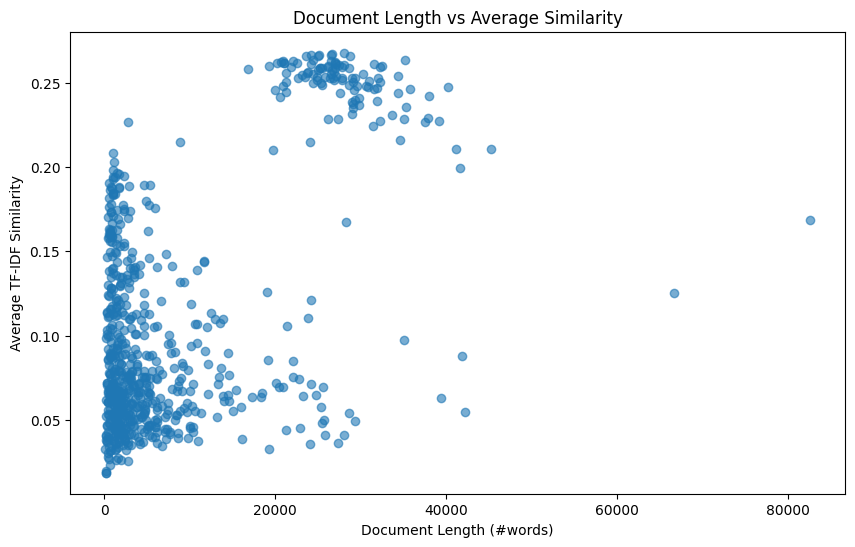

In [ ]:
# Document Length vs. Average TF-IDF Similarity

import numpy as np
import matplotlib.pyplot as plt

# Compute document length
df_docs['doc_length'] = df_docs['text'].apply(lambda x: len(x.split()))

# Average similarity for each document
df_docs['avg_similarity'] = cosine_sim.mean(axis=1)

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(df_docs['doc_length'], df_docs['avg_similarity'], alpha=0.6)
plt.xlabel("Document Length (#words)")
plt.ylabel("Average TF-IDF Similarity")
plt.title("Document Length vs Average Similarity")
plt.show()

Obervations:

  - There isn’t a strict linear relationship between document length and similarity.

  - Similarity depends not just on length, but on content overlap, which makes sense for legal documents: some long documents are very unique, and some moderate-length ones are repetitive.

Actionable Insights:

  - Documents with high similarity can be grouped to reduce redundancy in retrieval

  - Documents with very low similarity might represent rare contract types, which could be important edge cases for your RAG system

  - Outliers (extremely long or extremely short) may need preprocessing before embedding

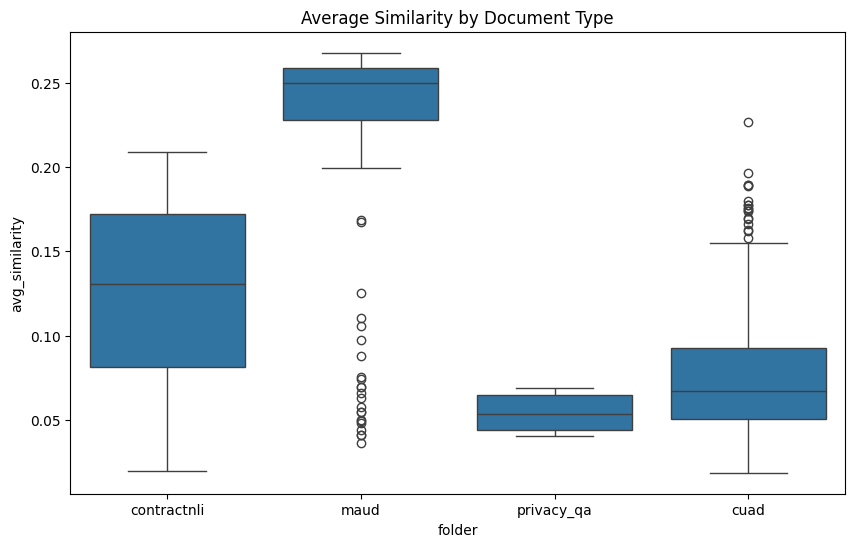

In [ ]:
# Document Type vs Average Similarity

import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='folder', y='avg_similarity', data=df_docs)
plt.title("Average Similarity by Document Type")
plt.show()


Obseravtions:

  - maud documents are the most similar on average, while privacy_qa documents show the least similarity.

  - The variability is highest in contractnli, suggesting diverse document types or content.

  - cuad shows a consistent low similarity with a long tail of outliers.

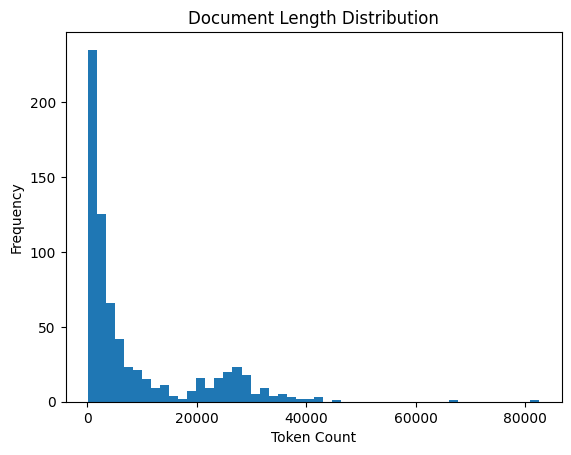

In [ ]:
# Plot document lengths (token count)

df_docs['token_count'] = df_docs['tokens'].apply(len)
plt.hist(df_docs['token_count'], bins=50)
plt.title('Document Length Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

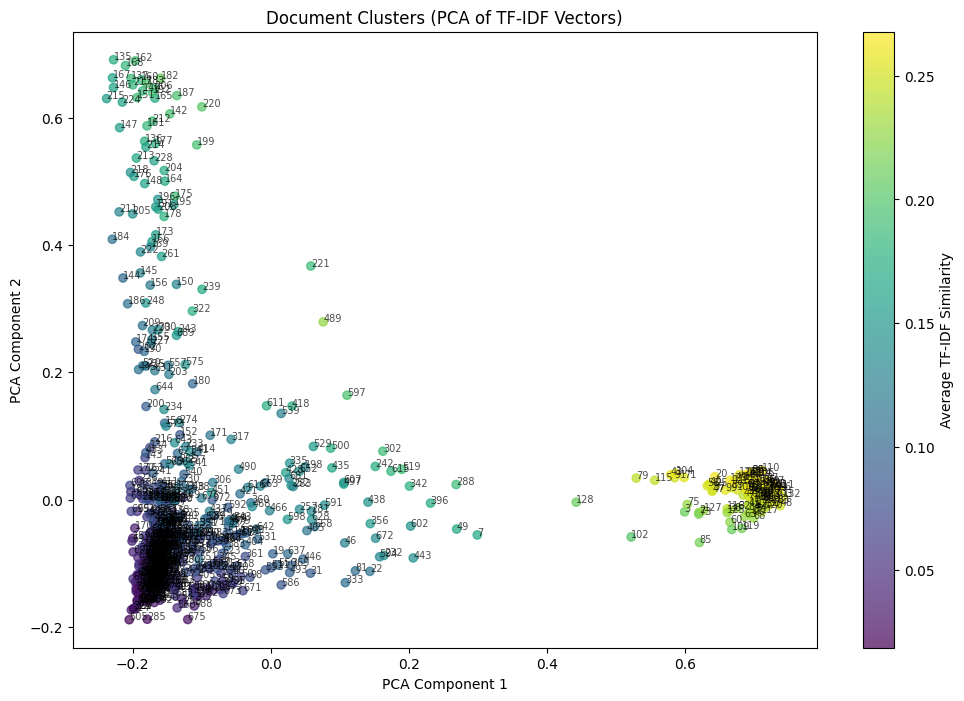

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce TF-IDF vectors to 2D
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

# Compute average similarity per document
avg_sim = cosine_sim.mean(axis=1)

# Plot the PCA scatter plot with labels
plt.figure(figsize=(12,8))
scatter = plt.scatter(tfidf_2d[:,0], tfidf_2d[:,1],
                      c=avg_sim, cmap="viridis", alpha=0.7)

# Add labels for each point (document index)
for i, txt in enumerate(df_docs.index):
    plt.annotate(txt, (tfidf_2d[i,0], tfidf_2d[i,1]), fontsize=7, alpha=0.7)

plt.colorbar(scatter, label="Average TF-IDF Similarity")
plt.title("Document Clusters (PCA of TF-IDF Vectors)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# ---------- 1. Run KMeans clustering ----------
num_clusters = 10   # you can tune this later
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
doc_clusters = kmeans.fit_predict(tfidf_matrix)

# Add cluster labels back into your dataframe
df_docs['cluster'] = doc_clusters

# ---------- 2. Extract top keywords per cluster ----------
# Get feature (word) names from TF-IDF
terms = tfidf_vectorizer.get_feature_names_out()

# For each cluster, find the top keywords
def get_top_keywords_per_cluster(kmeans, terms, n_terms=10):
    top_keywords = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        # sort terms by weight in cluster center
        top_indices = center.argsort()[::-1][:n_terms]
        top_terms = [terms[ind] for ind in top_indices]
        top_keywords[i] = top_terms
    return top_keywords

top_keywords = get_top_keywords_per_cluster(kmeans, terms, n_terms=10)

# ---------- 3. Print cluster keywords ----------
for cluster_num, keywords in top_keywords.items():
    print(f"\nCluster {cluster_num}:")
    print(", ".join(keywords))

# ---------- 4. Preview documents from each cluster ----------
for cluster_num in range(num_clusters):
    print(f"\n=== Cluster {cluster_num} Sample Docs ===")
    sample_docs = df_docs[df_docs['cluster'] == cluster_num]['text'].head(3).tolist()
    for doc in sample_docs:
        print(" -", doc[:200], "...")



Cluster 0:
licensee, licensor, agreement, shall, licensed, party, licensees, content, section, rights

Cluster 1:
company, parent, section, merger, agreement, subsidiaries, shall, sub, material, stock

Cluster 2:
buyer, seller, company, agreement, shall, sb, broker, buyers, information, business

Cluster 3:
company, agreement, shall, consultant, may, companys, party, section, prospectus, agent

Cluster 4:
party, information, confidential, agreement, disclosing, shall, receiving, recipient, parties, disclosure

Cluster 5:
distributor, shall, agreement, products, cisco, party, distributors, company, territory, product

Cluster 6:
agreement, shall, party, information, parties, may, section, services, confidential, date

Cluster 7:
talent, essi, csa, agreement, talents, shall, essis, property, company, legacy

Cluster 8:
venture, joint, shall, board, members, samed, agreement, member, participant, party

Cluster 9:
afi, arizona, licensed, hertz, armstrong, mar, apr, dec, sep, licensor

==

In [ ]:
df_docs['doc_length'] = df_docs['text'].apply(lambda x: len(x.split()))
df_docs['doc_length'].describe()


,doc_length
count,698.000000
mean,8620.320917
std,11006.397630
min,132.000000
25%,1358.000000
50%,3212.000000
75%,10845.750000
max,82546.000000


Observations:

  - Mean = ~8,600 words → these are long contracts (like 20–40 pages).

  - Max = 82,546 words 🤯 → some are huge (book-length filings).

  - Min = 132 words → a few short docs exist.
  
  - This makes chunking essential, otherwise embeddings will overflow token limits and semantic search will fail.

In [ ]:
df_docs['cluster'].value_counts()


,count
cluster,
6,388
1,110
4,68
3,67
5,26
0,20
2,8
8,6
9,3


Observations:

  - Cluster 6 dominates (388 docs) → very general “agreement” cluster

  - Next largest: Cluster 1 (110 docs)

  - Small clusters: 7 (2 docs), 9 (3 docs), 8 (6 docs)

Interpretation:

  - Cluster 6 probably absorbs “generic agreements” (confidentiality, services, etc.)

  - Small clusters may be niche agreements (like Talent / AFI)

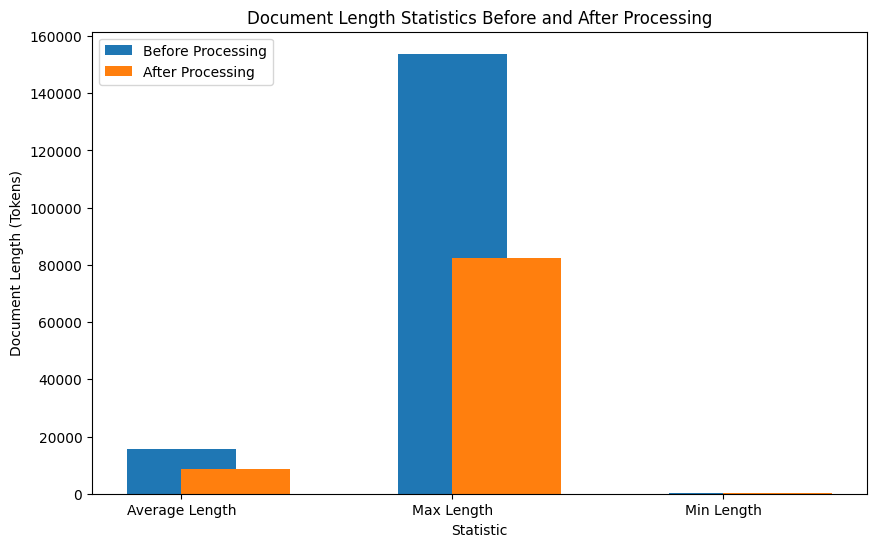

In [ ]:
# Comparing the document lengths before and after tokenizing

# Define the statistics for before and after processing
before_stats = [avg_length_bef, max_length_bef, min_length_bef]
after_stats = [avg_length_after, max_length_after, min_length_after]

# Define labels
labels = ['Average Length', 'Max Length', 'Min Length']

# Set the x positions
x = range(len(labels))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, before_stats, width=0.4, label='Before Processing', align='center')
plt.bar(x, after_stats, width=0.4, label='After Processing', align='edge')

# Add titles and labels
plt.title('Document Length Statistics Before and After Processing')
plt.xlabel('Statistic')
plt.ylabel('Document Length (Tokens)')
plt.xticks(x, labels)
plt.legend(loc='upper left')

# Display the plot
plt.show()



Observations:

  - There's about a 45% reduction in size overall

  - Stopwords, punctuation, numbers, and non-essentials were removed

  - Words are normalized (tokens), so redundancy goes down

Actionable Insights:

  - 82k words per doc is way too large for embedding at once, so chunking is the next mandatory step
  
  - Chunking easier to chunk because the text is already normalized.

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

### Implementing Fixed size, overlapping window chunking by word count which is simple, effective for most legal texts and maintaind some context via overlap



In [ ]:
# Process files and generate chunks

# Splits the document into overlapping chunks of words

def chunk_text_with_metadata(text, file_path, chunk_size=200, overlap=50):
    words = text.split()
    chunks = []
    current_char_index = 0

    for i in range(0, len(words), chunk_size - overlap):
        chunk_words = words[i:i + chunk_size]
        chunk_text = " ".join(chunk_words)

        # Estimate char position (good enough for most real-world use)
        chunk_start = text.find(chunk_text, current_char_index)
        chunk_end = chunk_start + len(chunk_text)
        current_char_index = chunk_end

        chunks.append({
            "text": chunk_text,
            "file_path": file_path,
            "chunk_id": f"{file_path}_chunk_{i}",
            "start_char": chunk_start,
            "end_char": chunk_end
        })

    return chunks

In [ ]:
# Flatten to one chunk per row to work at the chunk-level

all_chunks = []

for idx, row in df_docs.iterrows():
    file_path = row['file_path']
    text = row['cleaned_content']
    chunks = chunk_text_with_metadata(text, file_path, chunk_size=200, overlap=50)
    all_chunks.extend(chunks)

# Create a DataFrame from all chunks
df_chunks = pd.DataFrame(all_chunks)


In [ ]:
# Verfiy the dataframe after chunking

df_chunks.head(5)

,text,file_path,chunk_id,start_char,end_char
0,nondisclosure agreement this agreement is effe...,/content/legal_docs_dataset/rag_legal/corpus/c...,/content/legal_docs_dataset/rag_legal/corpus/c...,0,1254
1,this agreement for purposes of this definition...,/content/legal_docs_dataset/rag_legal/corpus/c...,/content/legal_docs_dataset/rag_legal/corpus/c...,-1,1280
2,of its affiliates discloses or makes available...,/content/legal_docs_dataset/rag_legal/corpus/c...,/content/legal_docs_dataset/rag_legal/corpus/c...,1917,3243
3,receiving party from a third party and is not ...,/content/legal_docs_dataset/rag_legal/corpus/c...,/content/legal_docs_dataset/rag_legal/corpus/c...,-1,1297
4,or use exceptions notwithstanding clause of th...,/content/legal_docs_dataset/rag_legal/corpus/c...,/content/legal_docs_dataset/rag_legal/corpus/c...,3862,5139


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [ ]:
!pip uninstall llama-index faiss-cpu faiss-gpu -y
!pip install llama-index faiss-cpu

Found existing installation: llama-index 0.13.2
Uninstalling llama-index-0.13.2:
  Successfully uninstalled llama-index-0.13.2
Found existing installation: faiss-cpu 1.12.0
Uninstalling faiss-cpu-1.12.0:
  Successfully uninstalled faiss-cpu-1.12.0
  Using cached llama_index-0.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached faiss_cpu-1.12.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.1 kB)
Using cached llama_index-0.13.2-py3-none-any.whl (7.0 kB)
Using cached faiss_cpu-1.12.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (31.4 MB)


In [ ]:
!pip install llama-index-vector-stores-faiss

In [ ]:
import os
import faiss
from tqdm import tqdm

from llama_index.core import Document, VectorStoreIndex, ServiceContext, StorageContext
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.faiss import FaissVectorStore

In [ ]:
# Fetch your OPENAI API Key as an environment variable

# Function to Initialize OpenAI embedding model
def init_llama_openai_embedding() -> OpenAIEmbedding:
    api_key = OPENAI_API_KEY
    if not api_key:
        raise ValueError("OPENAI_API_KEY environment variable not set.")
    return OpenAIEmbedding(api_key=api_key)


In [ ]:
# Initialise an embedding function

# Function to transform text to vectors

def embed_texts_llama(embed_model: OpenAIEmbedding, texts: list[str]) -> list[list[float]]:
    embeddings = []
    for text in tqdm(texts, desc="Embedding texts"):
        embeddings.append(embed_model.get_embedding(text))
    return embeddings

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
# Add Chunks to vector DB

# Convert your chunked dataframe to LlamaIndex Documents

llama_docs = [
    Document(
        text=row["text"],
        metadata={
            "file_path": row["file_path"],
            "chunk_id": row["chunk_id"],
            "start_char": row["start_char"],
            "end_char": row["end_char"],
        }
    )
    for _, row in df_chunks.iterrows()
]

In [ ]:
# Verify one example
print(llama_docs[0].metadata)

{'file_path': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/5-NSK-Confidentiality-Agreement-for-Suppliers.txt', 'chunk_id': '/content/legal_docs_dataset/rag_legal/corpus/contractnli/5-NSK-Confidentiality-Agreement-for-Suppliers.txt_chunk_0', 'start_char': 0, 'end_char': 1254}


In [ ]:
from llama_index.core.settings import Settings

# Configure default embedding model globally
Settings.embed_model = embed_model


In [ ]:
# Build the embedding model, FAISS store, and index

from llama_index.embeddings.openai import OpenAIEmbedding

# Step 1: Initialize embedding model and set as default
embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.embed_model = embed_model  # This replaces ServiceContext

# Step 2: Set up FAISS vector store
dimension = 1536  # for text-embedding-3-small
faiss_index = faiss.IndexFlatL2(dimension)
vector_store = FaissVectorStore(faiss_index=faiss_index)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Step 3: Building Vector Stor Index

print("Building vector store index from documents (embedding underway)...")
index = VectorStoreIndex.from_documents(
    documents=llama_docs,
    storage_context=storage_context,
    show_progress=True
)

Building vector store index from documents (embedding underway)...


Parsing nodes:   0%|          | 0/73340 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1660 [00:00<?, ?it/s]

In [ ]:
# Save to Google drive

save_path = "/content/drive/MyDrive/Colab Notebooks/vector_db_org"

# Save the entire index (includes vector store + metadata)
index.storage_context.persist(persist_dir="/content/drive/MyDrive/Colab Notebooks/vector_db_org")

print(f"✅ Vector store saved successfully at: {save_path}")

✅ Vector store saved successfully at: /content/drive/MyDrive/Colab Notebooks/vector_db_org


In [ ]:
# Load the Vector store back(without re-embedding)

# Re-initialize your embedding model (same one used for saving)

# Set embedding model again
embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.embed_model = embed_model

# Load from persisted directory
persist_dir = "/content/drive/MyDrive/Colab Notebooks/vector_db_org"
storage_context = StorageContext.from_defaults(persist_dir=persist_dir)

# Rebuild index
index = VectorStoreIndex.from_storage(storage_context)

### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
# Create a RAG Chain (Retriever + Generator)

query_engine = index.as_query_engine(
    similarity_top_k=3,     # fetch top 3 relevant chunks
    response_mode="compact",
    verbose=True
)

#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [ ]:
# Create a function for question answering


def answer_question_with_sources(question: str, query_engine):
    # Query using the query engine
    response = query_engine.query(question)

    # Extract source metadata
    sources_info = []
    for node in response.source_nodes:
        metadata = node.metadata
        source_data = {
            "file_path": metadata.get("file_path", "Unknown"),
            "chunk_id": metadata.get("chunk_id", "Unknown"),
            "start_char": metadata.get("start_char", None),
            "end_char": metadata.get("end_char", None),
            "text_snippet": node.get_text()[:500]  # get first 500 chars
        }
        sources_info.append(source_data)

    return {
        "answer": response.response,
        "sources": sources_info
    }

In [ ]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

# Example question
question = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

# Use the query engine here
result = answer_question_with_sources(question, query_engine)

print("Answer:\n", result["answer"])
print("\nSources:")
for s in result["sources"]:
    print(f"File: {s['file_path']}\n")
    print(f"Chunk: {s['chunk_id']}\n")
    print(f"Span: {s['start_char']} - {s['end_char']}\n")
    print(f"Snippet:\n{s['text_snippet']}\n")

Answer:
 The document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information.

Sources:
File: /content/legal_docs_dataset/rag_legal/corpus/contractnli/CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt

Chunk: /content/legal_docs_dataset/rag_legal/corpus/contractnli/CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt_chunk_1050

Span: -1 - 1351

Snippet:
commit to a nondisclosure agreement that protects the confidential information to at least the same degree as this agreement mentor shall take all reasonable measures to protect the secrecy of and avoid any unauthorised disclosure or use of confidential information such measures shall include the highest degree of care that mentor utilises to protect mentors own confidential information of a similar nature but no less than reasonable care notwithstanding mentors right to assess and rate the idea

File: /content/legal_docs_dataset/rag_legal/corpus/contractnli/CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt

Chunk: /

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [ ]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

import json
import os

def extract_qa_pairs(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    # If it's a dict, try to extract the list inside
    if isinstance(data, dict):
        for key in data:
            if isinstance(data[key], list):
                data = data[key]
                break

    if not isinstance(data, list):
        raise ValueError(f"Unexpected data format in {json_path}")

    questions = []
    answers = []

    for item in data:
        if not isinstance(item, dict):
            continue

        question = item.get("query")
        snippets = item.get("snippets", [])
        answer = " ".join([s.get("answer", "") for s in snippets if isinstance(s, dict)])

        if question and answer:
            questions.append(question.strip())
            answers.append(answer.strip())

    return questions, answers



In [ ]:
# Question and Answer Set Loading code

benchmark_dir = "/content/legal_docs_dataset/rag_legal/benchmarks"

all_questions = []
all_answers = []

for filename in os.listdir(benchmark_dir):
    if filename.endswith(".json"):
        file_path = os.path.join(benchmark_dir, filename)
        print(f"Loading: {file_path}")
        questions, answers = extract_qa_pairs(file_path)
        all_questions.extend(questions)
        all_answers.extend(answers)

print(f"\nTotal Questions Loaded: {len(all_questions)}")
print(f"\nTotal Questions Loaded: {len(all_answers)}")



Loading: /content/legal_docs_dataset/rag_legal/benchmarks/contractnli.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/privacy_qa.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/maud.json
Loading: /content/legal_docs_dataset/rag_legal/benchmarks/cuad.json

Total Questions Loaded: 6889

Total Questions Loaded: 6889


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

In [ ]:
def generate_rag_answers(index, questions, top_k=3):
    query_engine = index.as_query_engine(similarity_top_k=top_k)

    generated_answers = []
    generated_contexts = []

    for q in questions:
        response = query_engine.query(q)

        # Save the answer
        generated_answers.append(response.response.strip())

        # Save source document chunks (contexts)
        contexts = [node.node.text.strip() for node in response.source_nodes]
        generated_contexts.append(contexts)

    return generated_answers, generated_contexts


In [ ]:
# Run the Answer Generation

generated_answers, generated_contexts = generate_rag_answers(index, all_questions)

In [ ]:
# Save the RAG answers
# Create a save directory
save_dir = "/content/drive/MyDrive/Colab Notebooks/rag_outputs"
os.makedirs(save_dir, exist_ok=True)

# Save the full output to a JSON file
with open(f"{save_dir}/rag_outputs_full.json", "w") as f:
    json.dump({
        "questions": all_questions,
        "answers": generated_answers,
        "contexts": generated_contexts
    }, f)

print("Saved all generated answers, questions, and contexts to Drive.")


Saved all generated answers, questions, and contexts to Drive.


In [ ]:
# Reload the RAG answers

with open("/content/drive/MyDrive/Colab Notebooks/rag_outputs/rag_outputs_full.json", "r") as f:
    rag_data = json.load(f)

all_questions = rag_data["questions"]
generated_answers = rag_data["answers"]
generated_contexts = rag_data["contexts"]

print(f"Loaded {len(all_questions)} questions and answers.")


Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [ ]:
# Install the Metrics Libraries
!pip install rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24987 sha256=6392f0d13e570896a1a912b8b5694af733dd3e502c5466da8e2f093346fdc4d2
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
!pip install -q rouge-score nltk evaluate ragas datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Import Necessary modules

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Function to evaluate the RAG pipeline

def evaluate_all_metrics(questions, references, predictions, contexts=None):

    print("Starting BLEU + ROUGE Evaluation...")

    # Init scorers
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method1

    total_bleu = total_r1 = total_r2 = total_rl = 0.0
    count = len(questions)

    for ref, pred in zip(references, predictions):
        ref_tokens = [nltk.word_tokenize(ref)]
        pred_tokens = nltk.word_tokenize(pred)

        # BLEU
        bleu = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smooth_fn)
        total_bleu += bleu

        # ROUGE
        scores = rouge.score(ref, pred)
        total_r1 += scores['rouge1'].fmeasure
        total_r2 += scores['rouge2'].fmeasure
        total_rl += scores['rougeL'].fmeasure

    avg_bleu = total_bleu / count
    avg_rouge1 = total_r1 / count
    avg_rouge2 = total_r2 / count
    avg_rougeL = total_rl / count

    # Show results
    print("\n📊 BLEU & ROUGE Scores:")
    print(f"BLEU:     {avg_bleu:.4f}")
    print(f"ROUGE-1:  {avg_rouge1:.4f}")
    print(f"ROUGE-2:  {avg_rouge2:.4f}")
    print(f"ROUGE-L:  {avg_rougeL:.4f}")

    # RAGAS Evaluation
    if contexts:
        print("\n Starting RAGAS Evaluation...")

        # Build RAGAS-compatible dataset
        ragas_data = {
            "question": questions,
            "answer": predictions,
            "contexts": contexts,
            "ground_truth": references
        }

        ragas_dataset = Dataset.from_dict(ragas_data)

        result = ragas_evaluate(
            ragas_dataset,
            metrics=[
                answer_relevancy,
                context_precision,
                context_recall,
                faithfulness,
            ]
        )

        print("\n📊 RAGAS Scores:")
        for metric, score in result.items():
            print(f"{metric}: {score:.4f}")

    return {
        "bleu": avg_bleu,
        "rouge1": avg_rouge1,
        "rouge2": avg_rouge2,
        "rougeL": avg_rougeL
    }


In [ ]:
# Run evaluation

scores = evaluate_all_metrics(
    questions=all_questions,
    references=all_answers,
    predictions=generated_answers,
    contexts=generated_contexts  # optional for RAGAS; if unavailable, skip this
)

NameError: name 'generated_answers' is not defined

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
# Evaluate the RAG pipeline


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.